# Section 0. Summarization of Project

So the goal of this project is to utilize a Covid-19 dataset to identify Covid-Positive patients who were likely to die based on a small set of features. We're not expecting the most thorough detail, but it's a starting point for some healthcare modeling. One key component is treating it as a "real-time" prediction, i.e. if we would not be able to use the information during diagnosis then we will not be using the feature, or any variation of the feature.

**The Dataset**
The dataset consists of 21 unique features for 1,048,576 patients. This dataset was sourced from Kaggle (https://www.kaggle.com/datasets/meirnizri/covid19-dataset) courtesy of user *MEIR NIZRI*. A summary of the features is found below.


*   *SEX*: 1 for Female, 2 for Male
*   *AGE*: age of patient
*   *CLASIFFICATION_FINAL*: Covid Test findings. Values 1-3 mean that the patient was diagnosed with Covid in different degrees. 4 or higher means that the patient was not a carrier of Covid, or had an inconclusive test.
*   *PATIENT_TYPE*: Type of care the patient received in the unit. 1 for Returned Home and 2 for Hospitalization
*   *PNEUMONIA*: whether the patient already had air sac inflammation or not
*   *PREGNANT*: whether the patient was pregnant or not
*   *DIABETES*: whether the patient has diabetes or not
*   *COPD*: whether the patient has Chronic Obstructive Pulmonary Disease or not
*   *ASTHMA*: whether the patient has Asthma or not
*   *INMSUPR*: whether the patient is immunosuppressed or not
*   *HIPERTENSION*: whether the patient has hypertension or not.
*   *CARDIOVASCULAR*: whether the patient has heart or blood vessels related disease.
*   *RENAL_CHRONIC*: whether the patient has chronic renal disease or not.
*   *OTHER_DISEASE*: whether the patient has other disease or not.
*   *OBESITY*: whether the patient is obese or not.
*   *TOBACCO*: whether the patient is a tobacco user.
*   *USMER*: Indicates whether the patient treated medical units of the first, second or third level.
*   *MEDICAL_UNIT*: type of institution of the National Health System that provided the care.
*   *INTUBED*: whether the patient was connected to the ventilator.
*   *ICU*: Indicates whether the patient had been admitted to an Intensive Care Unit.
*   *DATE_DIED*: If the patient died indicate the date of death, and 9999-99-99 otherwise.



# Section 1. Imports and Basic Data Changes

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('covid_data.csv')
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97


In [3]:
# We want to drop some columns since we wouldn't be able to use them "in the moment" to predict the outcome of the patient.
covid_data = data.drop(columns={'PATIENT_TYPE', 'MEDICAL_UNIT', 'ICU', 'USMER', 'INTUBED'})

# We also want to do a little cleaning as far as the binary variables go. They are 1-2 in this dataset, but we'll use 0-1.
for feature in ['PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'CARDIOVASCULAR', 'OTHER_DISEASE', 'OBESITY', 'TOBACCO', 'RENAL_CHRONIC', 'HIPERTENSION']:
  #print(covid_data[feature].value_counts())
  covid_data[feature] = covid_data[feature].map({1:1,
                                                 2:0,
                                                 97:-1,
                                                 98:-1,
                                                 99:-1})
  #print(covid_data[feature].value_counts())

# Personally, too, I just want to make it easier so I will be doing a similar transformation on the Covid Classification feature.
# Since the severity of Covid is likely unavailable during evaluation, we will simply do Positive or Negative classifications
covid_data['CLASIFFICATION_FINAL'] = np.where(covid_data['CLASIFFICATION_FINAL'] > 3, 0, 1)

# Let's also fix the name of the above feature
covid_data = covid_data.rename(columns={'CLASIFFICATION_FINAL':'COVID_POSITIVE',
                                        'HIPERTENSION' : 'HYPERTENSION'})

covid_data.head()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,COVID_POSITIVE
0,1,03/05/2020,1,65,0,0,0,0,0,1,0,0,0,0,0,1
1,2,03/06/2020,1,72,-1,0,0,0,0,1,0,0,1,1,0,0
2,2,09/06/2020,0,55,-1,1,0,0,0,0,0,0,0,0,0,1
3,1,12/06/2020,0,53,0,0,0,0,0,0,0,0,0,0,0,0
4,2,21/06/2020,0,68,-1,1,0,0,0,1,0,0,0,0,0,1


In [4]:
# The feature list has been trimmed down to those we would likely have during evaluation upon coming to a healthcare facility. Now lets set the target.
covid_data['PATIENT_DIED'] = np.where(covid_data['DATE_DIED'] == '9999-99-99', 0, 1)
covid_data = covid_data.drop(columns={'DATE_DIED'})
covid_data.head()

,SEX,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,COVID_POSITIVE,PATIENT_DIED
0,1,1,65,0,0,0,0,0,1,0,0,0,0,0,1,1
1,2,1,72,-1,0,0,0,0,1,0,0,1,1,0,0,1
2,2,0,55,-1,1,0,0,0,0,0,0,0,0,0,1,1
3,1,0,53,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,0,68,-1,1,0,0,0,1,0,0,0,0,0,1,1


In [5]:
# Noticed an odd thing here and just want to do a sanity check - there are patients who appeared to have died without being Covid Positive.
# This is not outlandish by any means, but I just want to make sure it's not a weird thing with the data.
print('Covid Negative: \n', covid_data[covid_data['COVID_POSITIVE'] == 0]['PATIENT_DIED'].value_counts(), '\n')
print('Covid Positive: \n', covid_data[covid_data['COVID_POSITIVE'] == 1]['PATIENT_DIED'].value_counts())

Covid Negative: 
 PATIENT_DIED
0    633890
1     22706
Name: count, dtype: int64 

Covid Positive: 
 PATIENT_DIED
0    337743
1     54236
Name: count, dtype: int64


In [6]:
# Now let's only look at those who are Covid Positive to see who is at risk of dying.
covid_positive = covid_data[covid_data['COVID_POSITIVE'] == 1].drop(columns={'COVID_POSITIVE'})
covid_positive.head()

,SEX,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,PATIENT_DIED
0,1,1,65,0,0,0,0,0,1,0,0,0,0,0,1
2,2,0,55,-1,1,0,0,0,0,0,0,0,0,0,1
4,2,0,68,-1,1,0,0,0,1,0,0,0,0,0,1
5,1,1,40,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,64,0,0,0,0,0,0,0,0,0,0,0,0


At this point we have a pretty simple dataset with a handful of features. Let's see what we can do as far as model performance goes.

# Section 2. Feature Exploration



In [7]:
import matplotlib.pyplot as plt
import xgboost as xgb

## Section 2.1 Distributions

<function matplotlib.pyplot.show(close=None, block=None)>

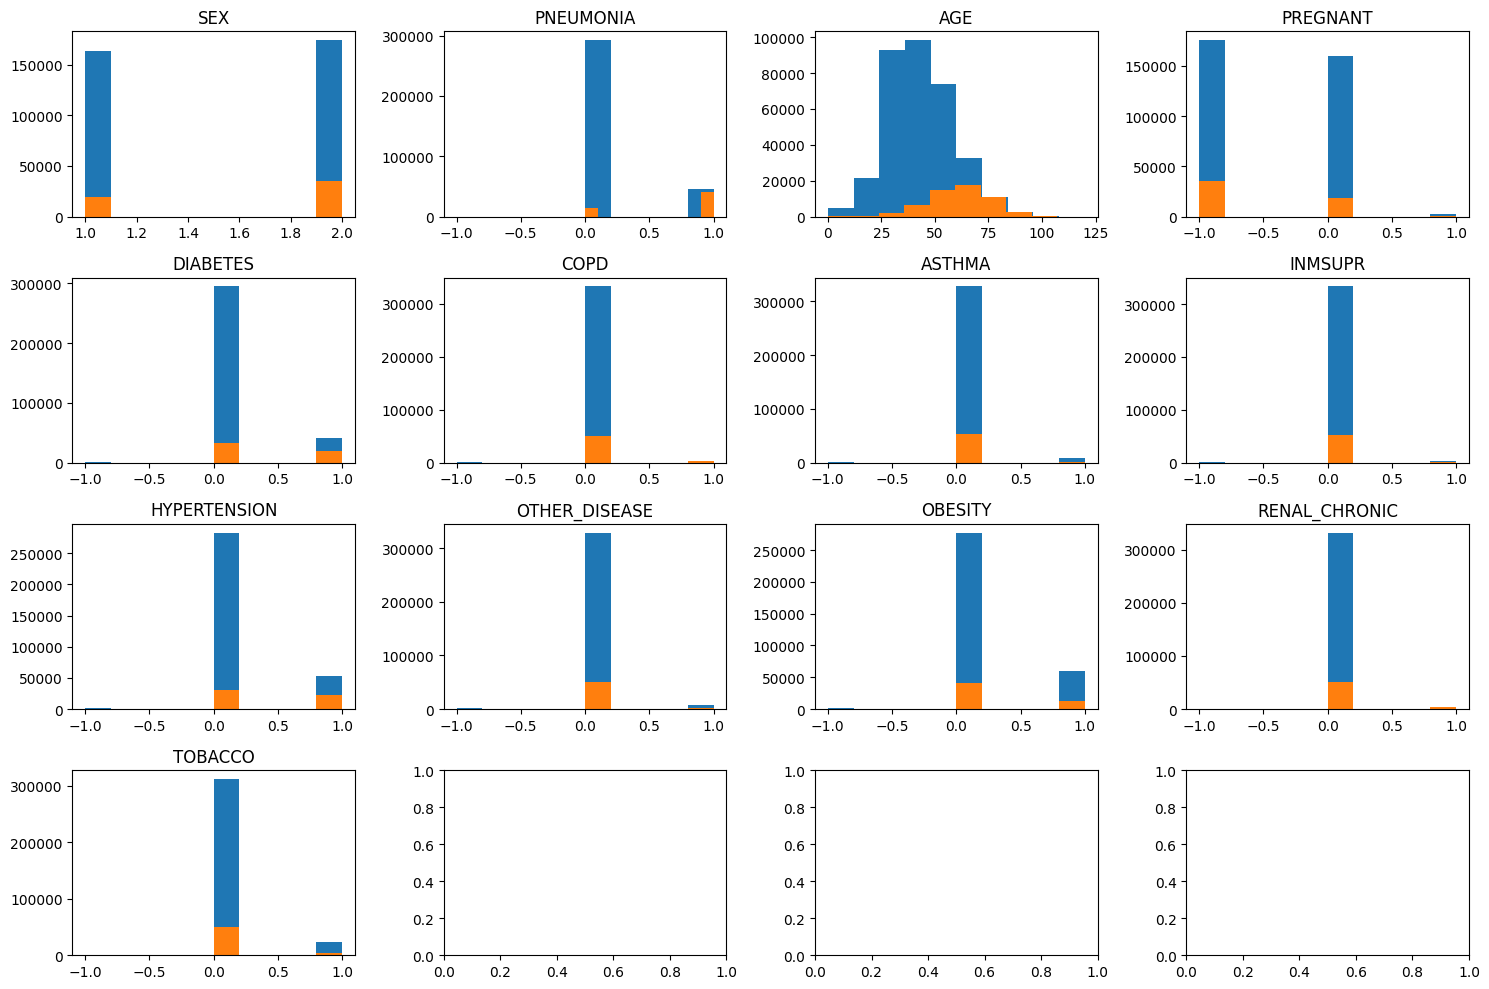

In [8]:
# Let's plot each feature dependent on if the patient died or not to see if there is a difference in distribution at all.

features = ['SEX', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
target = ['PATIENT_DIED']

fig, axs = plt.subplots(4, 4, figsize=(15, 10))

col = 0
row = 0

for feature in features:
  if col > 3:
    col = 0
    row += 1

  axs[row, col].hist(covid_positive[covid_positive['PATIENT_DIED'] == 0][feature])
  axs[row, col].hist(covid_positive[covid_positive['PATIENT_DIED'] == 1][feature])
  axs[row, col].set_title(feature)
  col += 1

plt.tight_layout()
plt.show

## Section 2.2 Summary Statistics

In [9]:
# Seems like that wasn't the most informative. Let's take a look at some summary statistics.

for feature in features:
  print(feature)
  print(covid_positive.groupby('PATIENT_DIED')[feature].describe(), '\n')

SEX
                 count      mean       std  min  25%  50%  75%  max
PATIENT_DIED                                                       
0             337743.0  1.515812  0.499751  1.0  1.0  2.0  2.0  2.0
1              54236.0  1.650435  0.476837  1.0  1.0  2.0  2.0  2.0 

PNEUMONIA
                 count      mean       std  min  25%  50%  75%  max
PATIENT_DIED                                                       
0             337743.0  0.134330  0.341042 -1.0  0.0  0.0  0.0  1.0
1              54236.0  0.749834  0.433112  0.0  0.0  1.0  1.0  1.0 

AGE
                 count       mean        std  min   25%   50%   75%    max
PATIENT_DIED                                                              
0             337743.0  42.563100  15.245250  0.0  31.0  41.0  52.0  120.0
1              54236.0  61.528118  14.180969  0.0  52.0  62.0  71.0  119.0 

PREGNANT
                 count      mean       std  min  25%  50%  75%  max
PATIENT_DIED                                           

## Section 2.3 Correlations

In [10]:
# Let's also take a look at some correlation.

for feature in features:
  print(feature)
  print(np.round(covid_positive[feature].corr(covid_positive['PATIENT_DIED']), 2))

SEX
0.09
PNEUMONIA
0.51
AGE
0.4
PREGNANT
-0.09
DIABETES
0.23
COPD
0.08
ASTHMA
-0.02
INMSUPR
0.03
HYPERTENSION
0.23
OTHER_DISEASE
0.04
OBESITY
0.06
RENAL_CHRONIC
0.11
TOBACCO
0.0


<Axes: >

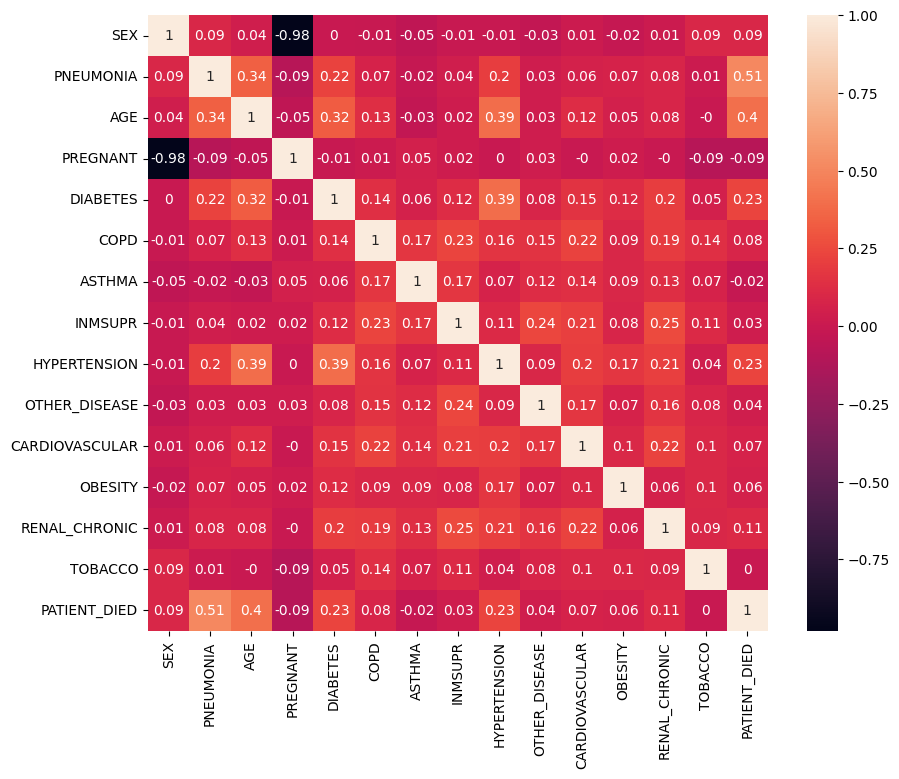

In [11]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(np.round(covid_positive.corr(), 2),annot=True)

# Section 3. Model Development

## Section 3.1 Rudimentary Model

In [12]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Here we're splitting the features and target into two separate dataframes.
data_features = covid_positive.drop(columns={'PATIENT_DIED'})
data_target = covid_positive['PATIENT_DIED']

# Now we'll split the data into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.15, random_state=412)

# Now to instantiate the model. We'll use a 'binary:logistic' objective to get probabilities.
model = XGBClassifier(objective='binary:logistic')

# Here we train the model
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

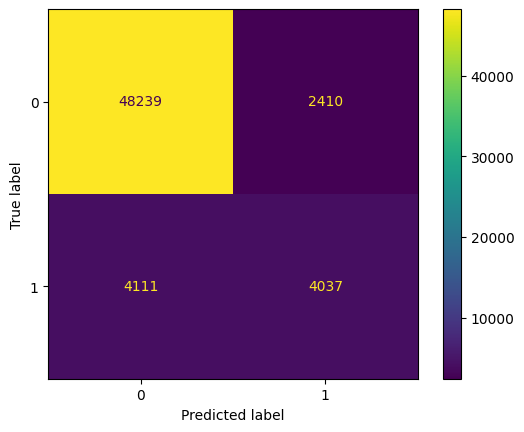

Accuracy:  88.91 %
Precision:  62.62 %
Recall:  49.55 %
F1:  55.32 %


In [13]:
# We should evaluate performance on the rudimentary model.
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

print('Accuracy: ', np.round(accuracy_score(y_test, y_pred)*100, 2), '%')
print('Precision: ', np.round(precision_score(y_test, y_pred)*100, 2), '%')
print('Recall: ', np.round(recall_score(y_test, y_pred)*100, 2), '%')
print('F1: ', np.round(f1_score(y_test, y_pred)*100, 2), '%')

You can see with this model, accuracy is not going to be the *best* metric to evaluate since the data is somewhat imbalanced. Let's focus on precision, recall, and F1. Using those, you can see it's not a phenomenal model.

## Section 3.2 More Complex Model

Disclaimer: The full iterative process on parameter tuning is not included, but was conducted as follows:

1.   [n_estimators, learning_rate]
2.   [max_depth, min_child_weight]
3.   [subsample, colsample_bytree]
4.   [colsample_bylevel, gamma, scale_pos_weight]

Over the course of four GridSearchCV runs (in an effort to reduce optimization time for this project), the listed parameters were tuned. The overall parameter grid used was:



```
param_grid = {
    'n_estimators': [10, 50, 100, 250, 500],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'colsample_bylevel': [0.5, 0.75, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [weight, weight/2, 1]
}
```

The first iteration of the grid search is kept for documentation.

In [14]:
from sklearn.model_selection import GridSearchCV

# Redefine the model
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

weight = (y_train == 0).sum() / (y_train == 1).sum()

# We'll use GridSearchCV to tune parameters, starting with the more important ones
param_grid = {
    'n_estimators': [10, 50, 100, 250, 500],
    #'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    #'subsample': [0.5, 0.75, 1.0],
    #'colsample_bytree': [0.5, 0.75, 1.0],
    #'colsample_bylevel': [0.5, 0.75, 1.0],
    #'min_child_weight': [1, 3, 5],
    #'gamma': [0, 0.1, 0.2, 0.3],
    #'scale_pos_weight': [weight, weight/2, 1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=False)
grid_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
print(best_model)

Best parameters:  {'learning_rate': 0.2, 'n_estimators': 50}
Best score:  0.5527702328466044
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


In [15]:
y_pred = best_model.predict(x_test)
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test F1-Score:", f1_score(y_test, y_pred))

Test Precision: 0.6296701578865093
Test Recall: 0.4943544428080511
Test F1-Score: 0.553867308353386


In [16]:
from sklearn.model_selection import GridSearchCV

weight = (y_train == 0).sum() / (y_train == 1).sum()

# Redefine the model
model = XGBClassifier(objective='binary:logistic',
                      eval_metric='logloss',
                      n_estimators=50,
                      learning_rate=0.2,
                      max_depth=4,
                      min_child_weight=3,
                      colsample_bytree=0.5,
                      subsample=1.0,
                      colsample_bylevel=0.5,
                      gamma=0.3,
                      scale_pos_weight=weight/2)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test F1-Score:", f1_score(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Precision: 0.5071225071225072
Test Recall: 0.7646048109965635
Test F1-Score: 0.6097978759849263
Test Accuracy: 0.8643978434273858
Test Confusion Matrix:
 [[44594  6055]
 [ 1918  6230]]


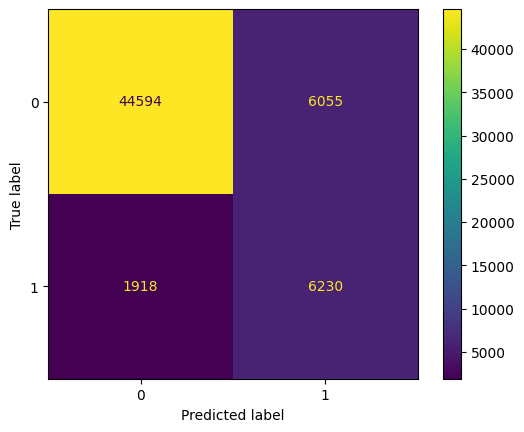

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

## 3.3 Incorporating Downsampling Instead of Weights

In this section I want to try using Downsampling instead of weighting the Positive class. Our recall isn't horrid in the most recent model, but our Precision is pretty low. During Covid a big issue was the number of ventilators available, so I'm inclined to focus more on reducing false positives than false negatives.

In [18]:
# How many of each class?

# We'll go back to the initial dataset pre-splitting for training/testing
data_features = covid_positive.drop(columns={'PATIENT_DIED'})
data_target = covid_positive['PATIENT_DIED']

print(data_target.value_counts())

PATIENT_DIED
0    337743
1     54236
Name: count, dtype: int64


We'll try two methods, one with a 1:1 ratio of Positive to Negative, and a 1:2 ratio of Positive to Negative

### 3.3.1 1:1 Class Balance

In [19]:
# Just taking a look at the dataset
print(covid_positive.head())

   SEX  PNEUMONIA  AGE  PREGNANT  DIABETES  COPD  ASTHMA  INMSUPR  \
0    1          1   65         0         0     0       0        0   
2    2          0   55        -1         1     0       0        0   
4    2          0   68        -1         1     0       0        0   
5    1          1   40         0         0     0       0        0   
6    1          0   64         0         0     0       0        0   

   HYPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  \
0             1              0               0        0              0   
2             0              0               0        0              0   
4             1              0               0        0              0   
5             0              0               0        0              0   
6             0              0               0        0              0   

   TOBACCO  PATIENT_DIED  
0        0             1  
2        0             1  
4        0             1  
5        0             0  
6    

In [20]:
# Let's split up the Positive/Negative At-Risk patients

covid_positive_died = covid_positive[covid_positive['PATIENT_DIED'] == 1]
covid_positive_not_died = covid_positive[covid_positive['PATIENT_DIED'] == 0]

print(covid_positive_died.shape)
print(covid_positive_not_died.shape)

(54236, 15)
(337743, 15)


In [29]:
from sklearn.utils import resample

# We'll take the covid_positive_not_died dataset and randomly downsample to reach 54,236 patients. We also need to be mindful of the representativeness of this sample to our full dataset.

downsampled_data = resample(
    covid_positive_not_died,
    replace=False,   # no replacement
    n_samples=54236, # match minority size
    random_state=412
)

print(downsampled_data.shape)

(54236, 15)


In [30]:
# Taking a look at representativeness, let's look at summary statistics and feature buckets to start.

for feature in covid_positive_not_died.columns:
  if feature != 'PATIENT_DIED':
    print(feature)
    print('Full Sample Mean: ', covid_positive_not_died[feature].mean())
    print('Downsampled Mean: ', downsampled_data[feature].mean(), '\n')
    print('Full Sample StDev : ', covid_positive_not_died[feature].std())
    print('Downsampled StDev : ', downsampled_data[feature].std(), '\n')

SEX
Full Sample Mean:  1.515812318834143
Downsampled Mean:  1.5170182166826462 

Full Sample StDev :  0.4997506478658351
Downsampled StDev :  0.4997149032501822 

PNEUMONIA
Full Sample Mean:  0.13432994910331228
Downsampled Mean:  0.13236595619145955 

Full Sample StDev :  0.341041705512412
Downsampled StDev :  0.3388913208991253 

AGE
Full Sample Mean:  42.56309975336276
Downsampled Mean:  42.56143520908621 

Full Sample StDev :  15.24524998801184
Downsampled StDev :  15.174490038487843 

PREGNANT
Full Sample Mean:  -0.5118240792555286
Downsampled Mean:  -0.5132937532266392 

Full Sample StDev :  0.5155427509864582
Downsampled StDev :  0.5151957545533113 

DIABETES
Full Sample Mean:  0.12083448065540958
Downsampled Mean:  0.12152444870565676 

Full Sample StDev :  0.3350641957286352
Downsampled StDev :  0.33619524081708635 

COPD
Full Sample Mean:  0.007937988352090199
Downsampled Mean:  0.0074858027878162104 

Full Sample StDev :  0.11527105188915303
Downsampled StDev :  0.1156158640

In [31]:
from scipy.stats import norm

# I want to be sure, even though they look similar, that they are not significantly different. We'll define some functions to do some Z-Testing

def z_test_means(mean1, mean2, var1, var2, n1, n2, alpha=0.05):
  # Calculate the Z-score
  z_score = (mean1 - mean2) / np.sqrt(var1 / n1 + var2 / n2)
  # Critical value
  z_critical = norm.ppf(1 - alpha / 2)
  return z_score, z_score > z_critical

def z_test_stddevs(std1, std2, n1, n2, alpha=0.05):
  # Calculate the Z-score for standard deviation
  z_score = (std1 - std2) / np.sqrt((std1 ** 2) / (2 * (n1 - 1)) + (std2 ** 2) / (2 * (n2 - 1)))
  # Critical value
  z_critical = norm.ppf(1 - alpha / 2)
  return z_score, z_score > z_critical

In [32]:
# Now we use them

for feature in covid_positive_not_died.columns:
  if feature != 'PATIENT_DIED':
    print(feature)
    full_mean, downsampled_mean = covid_positive_not_died[feature].mean(), downsampled_data[feature].mean()
    full_var, downsampled_var = covid_positive_not_died[feature].var(), downsampled_data[feature].var()
    full_std, downsampled_std = covid_positive_not_died[feature].std(), downsampled_data[feature].std()
    full_n, downsampled_n = len(covid_positive_not_died), len(downsampled_data)

    z_score_mean, mean_significant = z_test_means(full_mean, downsampled_mean, full_var, downsampled_var, full_n, downsampled_n)
    print("Z-score for means:", z_score_mean, "Significant:", mean_significant)

    z_score_std, std_significant = z_test_stddevs(full_std, downsampled_std, full_n, downsampled_n)
    print("Z-score for standard deviations:", z_score_std, "Significant:", std_significant)
    print('\n')

SEX
Z-score for means: -0.5216623868424791 Significant: False
Z-score for standard deviations: 0.02186759865878494 Significant: False


PNEUMONIA
Z-score for means: 1.2517076370968634 Significant: False
Z-score for standard deviations: 1.938164318537818 Significant: False


AGE
Z-score for means: 0.023697698503728912 Significant: False
Z-score for standard deviations: 1.424655290766567 Significant: False


PREGNANT
Z-score for means: 0.6166146638274813 Significant: False
Z-score for standard deviations: 0.2058871851962668 Significant: False


DIABETES
Z-score for means: -0.4438589059507947 Significant: False
Z-score for standard deviations: -1.0289809444040279 Significant: False


COPD
Z-score for means: 0.845831568760114 Significant: False
Z-score for standard deviations: -0.9121392984333678 Significant: False


ASTHMA
Z-score for means: 0.596117483069259 Significant: False
Z-score for standard deviations: -0.33788846683793533 Significant: False


INMSUPR
Z-score for means: 0.76459967

In [34]:
# Now that we see the downsampled data is not significantly different than our full dataset, let's build the model

# We need to concatenate the two datasets
one_to_one_covid_positive_data = pd.concat([downsampled_data, covid_positive_died])
print(one_to_one_covid_positive_data.shape)
print(one_to_one_covid_positive_data['PATIENT_DIED'].value_counts())

(108472, 15)
PATIENT_DIED
0    54236
1    54236
Name: count, dtype: int64


In [35]:
# Split the data

data_features = one_to_one_covid_positive_data.drop(columns={'PATIENT_DIED'})
data_target = one_to_one_covid_positive_data['PATIENT_DIED']

# Now we'll split the data into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.15, random_state=412)

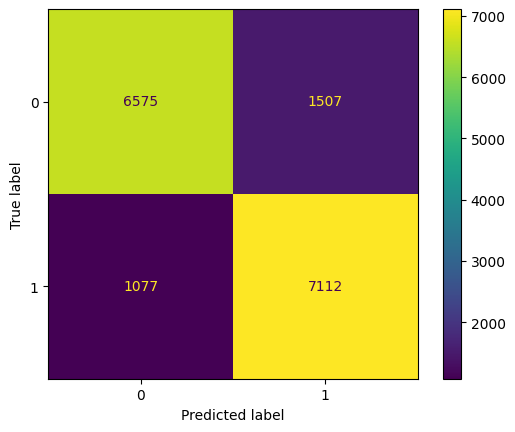

Accuracy:  84.12 %
Precision:  82.52 %
Recall:  86.85 %
F1:  84.63 %


In [36]:
# Rudimentary Model
model = XGBClassifier(objective='binary:logistic')

# Here we train the model
model.fit(x_train, y_train)

# We should evaluate performance on the rudimentary model.
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

print('Accuracy: ', np.round(accuracy_score(y_test, y_pred)*100, 2), '%')
print('Precision: ', np.round(precision_score(y_test, y_pred)*100, 2), '%')
print('Recall: ', np.round(recall_score(y_test, y_pred)*100, 2), '%')
print('F1: ', np.round(f1_score(y_test, y_pred)*100, 2), '%')

Now we're getting somewhere. Let's check 2:1 though before we move along

### 3.3.2 1:2 Class Balance

In [37]:
# Let's split up the Positive/Negative At-Risk patients

covid_positive_died = covid_positive[covid_positive['PATIENT_DIED'] == 1]
covid_positive_not_died = covid_positive[covid_positive['PATIENT_DIED'] == 0]

print(covid_positive_died.shape)
print(covid_positive_not_died.shape)

(54236, 15)
(337743, 15)


In [41]:
# We'll take the covid_positive_not_died dataset and randomly downsample to reach 2*54,236 patients. We also need to be mindful of the representativeness of this sample to our full dataset.

downsampled_data = resample(
    covid_positive_not_died,
    replace=False,   # no replacement
    n_samples=54236*2, # double minority size
    random_state=412
)

print(downsampled_data.shape)

(108472, 15)


In [42]:
# Taking a look at representativeness, let's look at summary statistics and feature buckets to start.

for feature in covid_positive_not_died.columns:
  if feature != 'PATIENT_DIED':
    print(feature)
    print('Full Sample Mean: ', covid_positive_not_died[feature].mean())
    print('Downsampled Mean: ', downsampled_data[feature].mean(), '\n')
    print('Full Sample StDev : ', covid_positive_not_died[feature].std())
    print('Downsampled StDev : ', downsampled_data[feature].std(), '\n')

SEX
Full Sample Mean:  1.515812318834143
Downsampled Mean:  1.517193377092706 

Full Sample StDev :  0.4997506478658351
Downsampled StDev :  0.499706603741304 

PNEUMONIA
Full Sample Mean:  0.13432994910331228
Downsampled Mean:  0.13476288811859283 

Full Sample StDev :  0.341041705512412
Downsampled StDev :  0.34147170755916073 

AGE
Full Sample Mean:  42.56309975336276
Downsampled Mean:  42.594549745556456 

Full Sample StDev :  15.24524998801184
Downsampled StDev :  15.227655190084604 

PREGNANT
Full Sample Mean:  -0.5118240792555286
Downsampled Mean:  -0.5134504756987979 

Full Sample StDev :  0.5155427509864582
Downsampled StDev :  0.515332447969678 

DIABETES
Full Sample Mean:  0.12083448065540958
Downsampled Mean:  0.12193930230842982 

Full Sample StDev :  0.3350641957286352
Downsampled StDev :  0.33633137726261153 

COPD
Full Sample Mean:  0.007937988352090199
Downsampled Mean:  0.007919094328490302 

Full Sample StDev :  0.11527105188915303
Downsampled StDev :  0.115944820453

In [43]:
# Now we use them

for feature in covid_positive_not_died.columns:
  if feature != 'PATIENT_DIED':
    print(feature)
    full_mean, downsampled_mean = covid_positive_not_died[feature].mean(), downsampled_data[feature].mean()
    full_var, downsampled_var = covid_positive_not_died[feature].var(), downsampled_data[feature].var()
    full_std, downsampled_std = covid_positive_not_died[feature].std(), downsampled_data[feature].std()
    full_n, downsampled_n = len(covid_positive_not_died), len(downsampled_data)

    z_score_mean, mean_significant = z_test_means(full_mean, downsampled_mean, full_var, downsampled_var, full_n, downsampled_n)
    print("Z-score for means:", z_score_mean, "Significant:", mean_significant)

    z_score_std, std_significant = z_test_stddevs(full_std, downsampled_std, full_n, downsampled_n)
    print("Z-score for standard deviations:", z_score_std, "Significant:", std_significant)
    print('\n')

SEX
Z-score for means: -0.7918948606097914 Significant: False
Z-score for standard deviations: 0.03571550814048439 Significant: False


PNEUMONIA
Z-score for means: -0.36339991435958957 Significant: False
Z-score for standard deviations: -0.5104367608589038 Significant: False


AGE
Z-score for means: -0.5916234849172611 Significant: False
Z-score for standard deviations: 0.4680825743199731 Significant: False


PREGNANT
Z-score for means: 0.9042234340766001 Significant: False
Z-score for standard deviations: 0.1653515123330335 Significant: False


DIABETES
Z-score for means: -0.9421110388378364 Significant: False
Z-score for standard deviations: -1.528136239999646 Significant: False


COPD
Z-score for means: 0.04675904202194449 Significant: False
Z-score for standard deviations: -2.3581162948082097 Significant: False


ASTHMA
Z-score for means: 0.5771774495130438 Significant: False
Z-score for standard deviations: 0.8572202606802037 Significant: False


INMSUPR
Z-score for means: 0.5773

In [44]:
# Now that we see the downsampled data is not significantly different than our full dataset, let's build the model

# We need to concatenate the two datasets
one_to_one_covid_positive_data = pd.concat([downsampled_data, covid_positive_died])
print(one_to_one_covid_positive_data.shape)
print(one_to_one_covid_positive_data['PATIENT_DIED'].value_counts())

(162708, 15)
PATIENT_DIED
0    108472
1     54236
Name: count, dtype: int64


In [45]:
# Split the data

data_features = one_to_one_covid_positive_data.drop(columns={'PATIENT_DIED'})
data_target = one_to_one_covid_positive_data['PATIENT_DIED']

# Now we'll split the data into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.15, random_state=412)

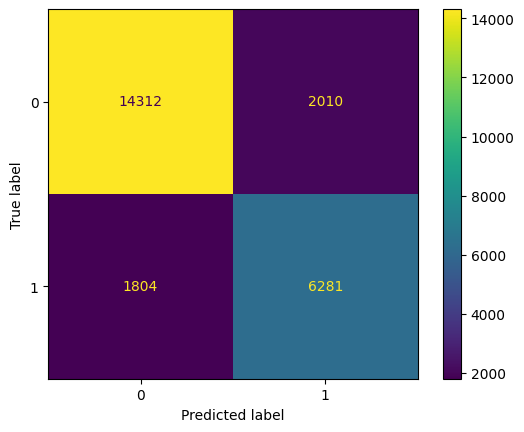

Accuracy:  84.37 %
Precision:  75.76 %
Recall:  77.69 %
F1:  76.71 %


In [46]:
# Rudimentary Model
model = XGBClassifier(objective='binary:logistic')

# Here we train the model
model.fit(x_train, y_train)

# We should evaluate performance on the rudimentary model.
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

print('Accuracy: ', np.round(accuracy_score(y_test, y_pred)*100, 2), '%')
print('Precision: ', np.round(precision_score(y_test, y_pred)*100, 2), '%')
print('Recall: ', np.round(recall_score(y_test, y_pred)*100, 2), '%')
print('F1: ', np.round(f1_score(y_test, y_pred)*100, 2), '%')

The 1:1 is performing better, so let's work more with that one.

## 3.4 More Expansive Downsampled Model

In [49]:
# We'll again go back to the initial dataset pre-splitting for training/testing
print(covid_positive['PATIENT_DIED'].value_counts())

PATIENT_DIED
0    337743
1     54236
Name: count, dtype: int64


In [51]:
# I want to be more stringent with the Validation set, so let's maintain the appropriate class imbalance and set aside a full set
covid_positive_died = covid_positive[covid_positive['PATIENT_DIED'] == 1]
covid_positive_not_died = covid_positive[covid_positive['PATIENT_DIED'] == 0]

# Let's target 15% total sample, so we'll just randomly sample 15% of both died and not died and concatenate into our validation set
train_died, test_died = train_test_split(covid_positive_died, test_size=0.15, random_state=412)
train_not_died, test_not_died = train_test_split(covid_positive_not_died, test_size=0.15, random_state=412)

train = pd.concat([train_died, train_not_died])
test = pd.concat([test_died, test_not_died])

print(train.shape)
print(test.shape)

print(train['PATIENT_DIED'].value_counts())
print(test['PATIENT_DIED'].value_counts())

(333181, 15)
(58798, 15)
PATIENT_DIED
0    287081
1     46100
Name: count, dtype: int64
PATIENT_DIED
0    50662
1     8136
Name: count, dtype: int64


In [56]:
train_died = train[train['PATIENT_DIED'] == 1]
train_not_died = train[train['PATIENT_DIED'] == 0]

# Now we can downsample the training data
downsampled_train_not_died = resample(
    train_not_died,
    replace=False,   # no replacement
    n_samples=46100, # match minority size
    random_state=42
)

print(downsampled_train_not_died.shape)

(46100, 15)


In [57]:
# Make sure representative again
for feature in downsampled_train_not_died.columns:
  if feature != 'PATIENT_DIED':
    print(feature)
    full_mean, downsampled_mean = train_not_died[feature].mean(), downsampled_train_not_died[feature].mean()
    full_var, downsampled_var = train_not_died[feature].var(), downsampled_train_not_died[feature].var()
    full_std, downsampled_std = train_not_died[feature].std(), downsampled_train_not_died[feature].std()
    full_n, downsampled_n = len(train_not_died), len(downsampled_train_not_died)

    z_score_mean, mean_significant = z_test_means(full_mean, downsampled_mean, full_var, downsampled_var, full_n, downsampled_n)
    print("Z-score for means:", z_score_mean, "Significant:", mean_significant)

    z_score_std, std_significant = z_test_stddevs(full_std, downsampled_std, full_n, downsampled_n)
    print("Z-score for standard deviations:", z_score_std, "Significant:", std_significant)
    print('\n')

SEX
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: 4.769246692551241e-14 Significant: False


PNEUMONIA
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: -1.3358869950181987e-12 Significant: False


AGE
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: 5.976680734534428e-13 Significant: False


PREGNANT
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: -9.245061088306658e-13 Significant: False


DIABETES
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: 3.621401529385291e-12 Significant: False


COPD
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: -5.7649347204715e-13 Significant: False


ASTHMA
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: -1.0044666566608567e-12 Significant: False


INMSUPR
Z-score for means: 0.0 Significant: False
Z-score for standard deviations: 1.1268596632900885e-11 Significant: Fal

In [58]:
# We'll concatenate again
train = pd.concat([downsampled_train_not_died, train_died])
print(train.shape)
print(train['PATIENT_DIED'].value_counts())

(92200, 15)
PATIENT_DIED
0    46100
1    46100
Name: count, dtype: int64


In [61]:
x_train = train.drop(columns={'PATIENT_DIED'})
y_train = train['PATIENT_DIED']

x_test = test.drop(columns={'PATIENT_DIED'})
y_test = test['PATIENT_DIED']

print(test['PATIENT_DIED'].value_counts())

PATIENT_DIED
0    50662
1     8136
Name: count, dtype: int64


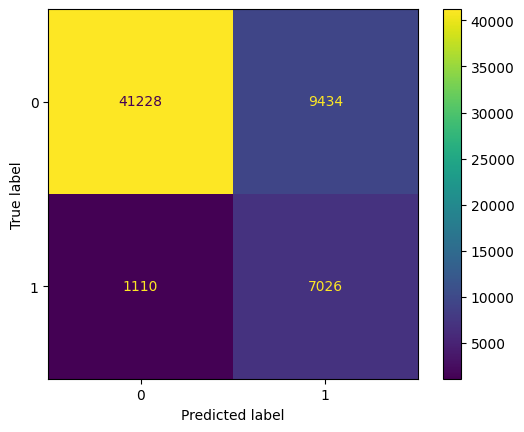

Accuracy:  82.07 %
Precision:  42.69 %
Recall:  86.36 %
F1:  57.13 %


In [66]:
# Rudimentary Model
model = XGBClassifier(objective='binary:logistic')

# Here we train the model
model.fit(x_train, y_train)

# We should evaluate performance on the rudimentary model.
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

print('Accuracy: ', np.round(accuracy_score(y_test, y_pred)*100, 2), '%')
print('Precision: ', np.round(precision_score(y_test, y_pred)*100, 2), '%')
print('Recall: ', np.round(recall_score(y_test, y_pred)*100, 2), '%')
print('F1: ', np.round(f1_score(y_test, y_pred)*100, 2), '%')

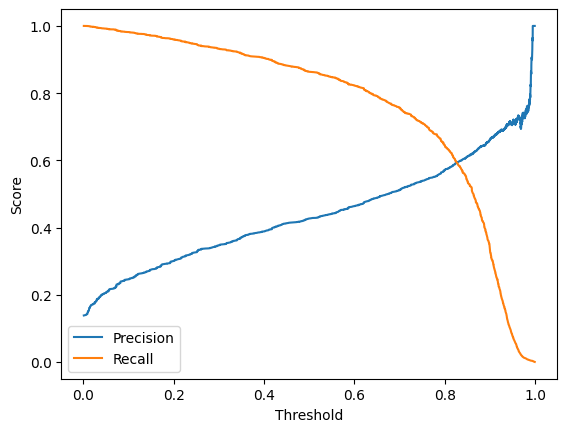

In [64]:
# Let's try to optimize to reduce false positives
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score

y_probs = model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

Threshold:  0.7


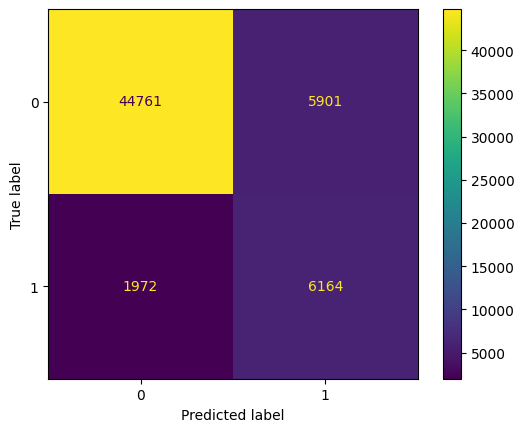

Accuracy:  86.61 %
Precision:  51.09 %
Recall:  75.76 %
F1:  61.03 %
Threshold:  0.75


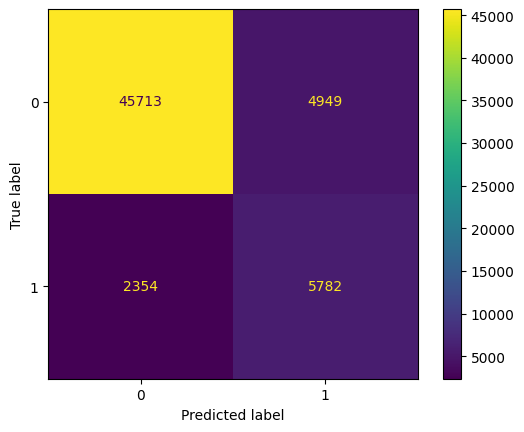

Accuracy:  87.58 %
Precision:  53.88 %
Recall:  71.07 %
F1:  61.29 %
Threshold:  0.8


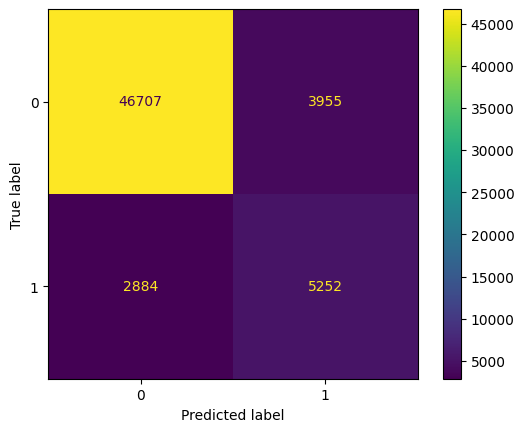

Accuracy:  88.37 %
Precision:  57.04 %
Recall:  64.55 %
F1:  60.57 %
Threshold:  0.85


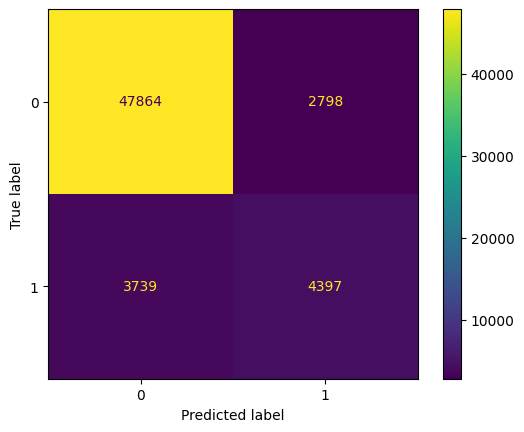

Accuracy:  88.88 %
Precision:  61.11 %
Recall:  54.04 %
F1:  57.36 %
Threshold:  0.9


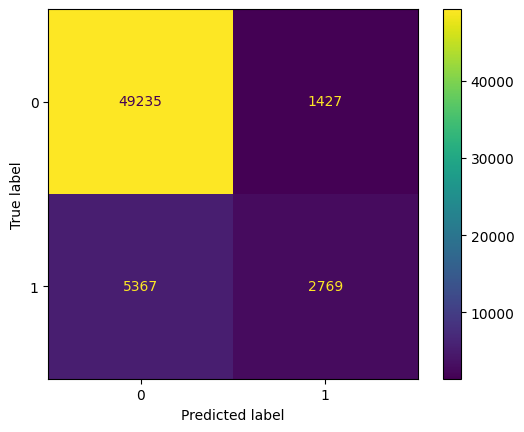

Accuracy:  88.45 %
Precision:  65.99 %
Recall:  34.03 %
F1:  44.91 %


In [65]:
# Let's test an alternative threshold

threshold_tests = [0.7, 0.75, 0.8, 0.85, 0.9]

for threshold in threshold_tests:
  print('Threshold: ', threshold)
  y_pred = (y_probs >= threshold).astype(int)
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
  disp.plot()
  plt.show()

  print('Accuracy: ', np.round(accuracy_score(y_test, y_pred)*100, 2), '%')
  print('Precision: ', np.round(precision_score(y_test, y_pred)*100, 2), '%')
  print('Recall: ', np.round(recall_score(y_test, y_pred)*100, 2), '%')
  print('F1: ', np.round(f1_score(y_test, y_pred)*100, 2), '%')

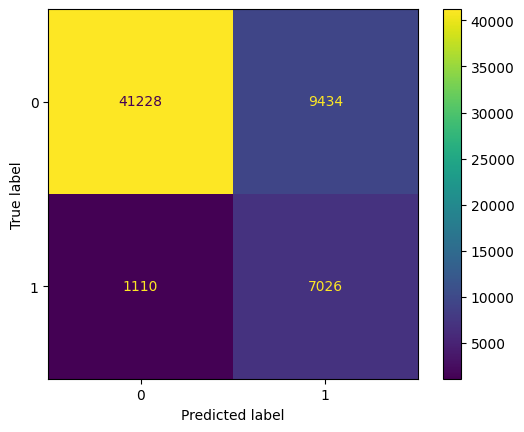

Accuracy:  82.07 %
Precision:  42.69 %
Recall:  86.36 %
F1:  57.13 %


In [67]:
# Now what if we try an Ensemble model of positive predictions?
# Let's use the base model as defined and built further above
# Rudimentary Model
model = XGBClassifier(objective='binary:logistic')

# Here we train the model
model.fit(x_train, y_train)

# We should evaluate performance on the rudimentary model.
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

print('Accuracy: ', np.round(accuracy_score(y_test, y_pred)*100, 2), '%')
print('Precision: ', np.round(precision_score(y_test, y_pred)*100, 2), '%')
print('Recall: ', np.round(recall_score(y_test, y_pred)*100, 2), '%')
print('F1: ', np.round(f1_score(y_test, y_pred)*100, 2), '%')

In [69]:
# Let's get the predictions incorporated
new_data = x_test
new_data['PATIENT_DIED'] = y_test
new_data['pred'] = y_pred

print(new_data.shape)

(58798, 16)


In [70]:
positive_predictions = new_data[new_data['pred'] == 1]
print(positive_predictions.shape)

(16460, 16)


(13991, 14)
(2469, 14)


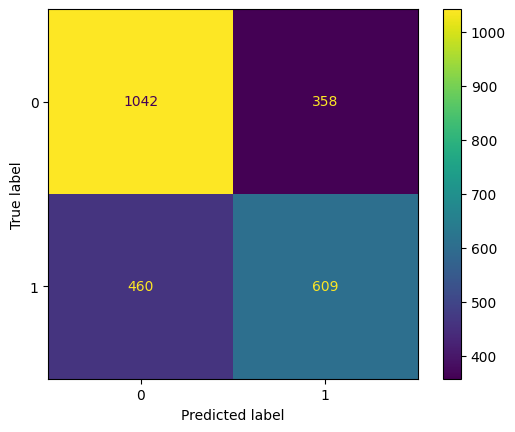

Accuracy:  66.87 %
Precision:  62.98 %
Recall:  56.97 %
F1:  59.82 %


In [72]:
# Now we split our data again
data_features = positive_predictions.drop(columns={'PATIENT_DIED', 'pred'})
data_target = positive_predictions['PATIENT_DIED']

# Now we'll split the data into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.15, random_state=412)
print(x_train.shape)
print(x_test.shape)

# Rudimentary Model
model = XGBClassifier(objective='binary:logistic')

# Here we train the model
model.fit(x_train, y_train)

# We should evaluate performance on the rudimentary model.
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

print('Accuracy: ', np.round(accuracy_score(y_test, y_pred)*100, 2), '%')
print('Precision: ', np.round(precision_score(y_test, y_pred)*100, 2), '%')
print('Recall: ', np.round(recall_score(y_test, y_pred)*100, 2), '%')
print('F1: ', np.round(f1_score(y_test, y_pred)*100, 2), '%')

Recall is much lower here, but precision is better at least.